---
#   **LRS**
---

## **Import Libraries**

In [9]:
import os
import cv2
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from PIL.TiffTags import TAGS
import pandas as pd

## **Define Paths**

In [10]:
main_image_path = "./dataset/20241014aC0822230w275445n.tif"
mask_path = "./mask-semantic/train/tile_9_jpg.rf.d7787040bfb812b5c96c58b53fef6be3_mask.png"

## **Check the MetaData of Main Image**

In [11]:
def get_tiff_metadata(image_path):
    image = Image.open(image_path)

    metadata = {}
    for tag, value in image.tag_v2.items():
        tag_name = TAGS.get(tag, tag)
        metadata[tag] = (tag_name, value)
    return metadata

image_path = main_image_path
metadata = get_tiff_metadata(image_path)
for tag, (tag_name, value) in metadata.items():
    print(f"Tag {tag} ({tag_name}): {value}")

Tag 256 (ImageWidth): 4707
Tag 257 (ImageLength): 4707
Tag 258 (BitsPerSample): (8, 8, 8)
Tag 259 (Compression): 7
Tag 322 (TileWidth): 512
Tag 323 (TileLength): 512
Tag 262 (PhotometricInterpretation): 6
Tag 324 (TileOffsets): (3680375, 3777342, 3874539, 3974094, 4067887, 4163194, 4260106, 4346861, 4421322, 4504248, 4543545, 4636357, 4744646, 4839237, 4937669, 5033638, 5131866, 5223846, 5323384, 5421219, 5467834, 5567045, 5666985, 5778154, 5873792, 5969234, 6070526, 6170798, 6269636, 6360653, 6412534, 6504994, 6588720, 6679546, 6774604, 6868877, 6961875, 7057827, 7149566, 7241186, 7287588, 7383497, 7479058, 7562464, 7662875, 7765199, 7865158, 7960415, 8059860, 8157478, 8204487, 8304118, 8402523, 8489859, 8592679, 8692619, 8792532, 8893842, 8980820, 9076774, 9126317, 9230001, 9336271, 9432219, 9532308, 9632017, 9733621, 9831860, 9927145, 10020012, 10071258, 10181498, 10289485, 10400410, 10506585, 10611864, 10710707, 10811044, 10911466, 11007177, 11054400, 11154126, 11258533, 11369547, 

## **Extract GSD from Main Image**

### **Ground Sampling Distance (GSD) Calculation:**
- Purpose: Converts pixel measurements to real-world distances
- Formula: 
```
meters_per_degree_lat = 111319.9  # Earth's circumference / 360°
meters_per_degree_lon = meters_per_degree_lat * cos(latitude)
gsd_x = pixel_scale_x * meters_per_degree_lon
gsd_y = pixel_scale_y * meters_per_degree_lat
```

In [12]:
main_image_path = main_image_path
with Image.open(main_image_path) as img:
    metadata = img.tag_v2
    model_pixel_scale = metadata.get(33550)
    pixel_scale_x, pixel_scale_y = model_pixel_scale[0], model_pixel_scale[1]
    latitude = metadata.get(33922)[4]
    meters_per_degree_lat = 111319.9
    meters_per_degree_lon = meters_per_degree_lat * math.cos(math.radians(latitude))
    gsd_x = pixel_scale_x * meters_per_degree_lon
    gsd_y = pixel_scale_y * meters_per_degree_lat

# Calculate the Pixel of road 

In [13]:

mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

binary_mask = (mask_img > 0).astype(np.uint8)

total_road_pixels = np.sum(binary_mask == 1)
total_non_road_pixels = np.sum(binary_mask == 0)
total_pixels = binary_mask.size 

num_labels, labels = cv2.connectedComponents(binary_mask)

colored_mask = np.zeros((mask_img.shape[0], mask_img.shape[1], 3), dtype=np.uint8)

road_pixel_counts = {}
for label in range(1, num_labels):  
    road_pixels = np.sum(labels == label)
    road_pixel_counts[label] = road_pixels
    
    colored_mask[labels == label] = [np.random.randint(100, 255), np.random.randint(100, 255), np.random.randint(100, 255)]

output_image = cv2.cvtColor(colored_mask, cv2.COLOR_RGB2BGR)


for label in range(1, num_labels):
    y, x = np.argwhere(labels == label).mean(axis=0).astype(int) 
    cv2.putText(output_image, f"Road {label}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2, cv2.LINE_AA)

# Compute average horizontal and vertical distances for each road (label)

In [14]:

road_dimensions = {}
for label in range(1, num_labels):  # ignoring background (label 0)
    # Horizontal distances (row-wise)
    horizontal_distances = []
    for row in range(labels.shape[0]):
        indices = np.where(labels[row] == label)[0]
        if indices.size > 0:
            horizontal_distances.append(indices[-1] - indices[0])
    avg_horizontal = np.mean(horizontal_distances) if horizontal_distances else 0

    # Vertical distances (column-wise)
    vertical_distances = []
    for col in range(labels.shape[1]):
        indices = np.where(labels[:, col] == label)[0]
        if indices.size > 0:
            vertical_distances.append(indices[-1] - indices[0])
    avg_vertical = np.mean(vertical_distances) if vertical_distances else 0

    wide = min(avg_horizontal, avg_vertical)
    length = max(avg_horizontal, avg_vertical)
    
    road_dimensions[label] = {
        "avg_horizontal": avg_horizontal,
        "avg_vertical": avg_vertical,
        "wide_pixel": wide,
        # "length": length
    }

In [15]:
for label in road_dimensions:
    road_dimensions[label]['avg_horizontal_m'] = road_dimensions[label]['avg_horizontal'] * gsd_x
    road_dimensions[label]['avg_vertical_m'] = road_dimensions[label]['avg_vertical'] * gsd_y
    road_dimensions[label]['width in Meter'] = min(road_dimensions[label]['avg_horizontal_m'], road_dimensions[label]['avg_vertical_m'])
    # road_dimensions[label]['length_m'] = max(road_dimensions[label]['avg_horizontal_m'], road_dimensions[label]['avg_vertical_m'])

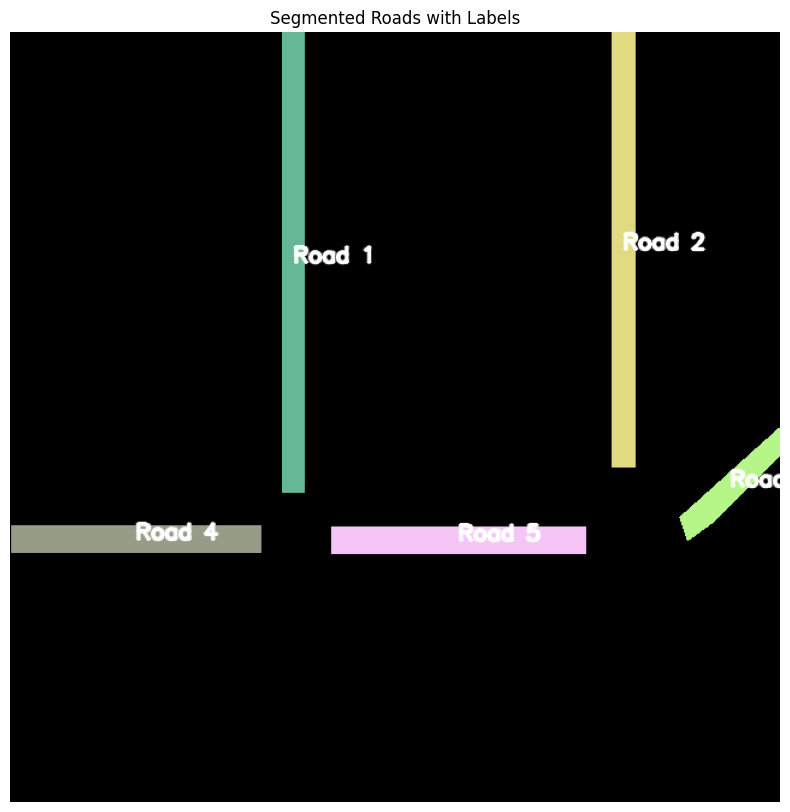

=== Road Pixel Counts (Per Road) ===
 Road  Pixel Count
    1         7277
    2         7240
    3         2206
    4         4784
    5         4876

=== Road Dimensions (Horizontal and Vertical) ===
      avg_horizontal  avg_vertical  wide_pixel  avg_horizontal_m  avg_vertical_m  width in Meter
Road                                                                                            
1          18.000000    382.000000   18.000000          4.777397      114.734940        4.777397
2          19.000000    361.000000   19.000000          5.042808      108.427522        5.042808
3          22.468085     25.261905   22.468085          5.963276        7.587495        5.963276
4         207.000000     22.000000   22.000000         54.940070        6.607771        6.607771
5         211.000000     22.000000   22.000000         56.001714        6.607771        6.607771
Latitude extracted for GSD calculation: 27.9125986509454
meters_per_degree_lat: 111319.9, meters_per_degree_lon: 98369.

In [16]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.title("Segmented Roads with Labels")
plt.axis("off")
plt.show()

print("===============================================================================================")
df_pixel_counts = pd.DataFrame(list(road_pixel_counts.items()), columns=["Road", "Pixel Count"])
print("=== Road Pixel Counts (Per Road) ===")
print(df_pixel_counts.to_string(index=False))
print("===============================================================================================")
df_road_dimensions = pd.DataFrame.from_dict(road_dimensions, orient="index")
df_road_dimensions.index.name = "Road"
print("\n=== Road Dimensions (Horizontal and Vertical) ===")
print(df_road_dimensions.to_string())

print("===============================================================================================")
print("Latitude extracted for GSD calculation:", latitude)
print(f"meters_per_degree_lat: {meters_per_degree_lat}, meters_per_degree_lon: {meters_per_degree_lon}")
print(f"Ground Sampling Distance (GSD) calculated: gsd_x = {gsd_x}, gsd_y = {gsd_y}")
